# Crucible 4: h_mean Trajectory Across the Sky

**Purpose:** Trace h_mean's path across the celestial sphere from t=1 to t=5000.

**Questions:**
1. Does h_mean lock onto one direction early and stay there (wibble-wobbling)?
2. Or does it wander across the sky over training?
3. Is the high autocorrelation (mean 0.9976) consistent with a locked direction, or does it accumulate into significant drift?

**Method:** Load all h_mean[t] vectors, project to spherical coordinates using the same PCA basis as sky_map_t5000.ipynb, plot the trajectory on Mollweide projection.

## Parameters

In [94]:
# PCA basis selection (1-indexed, same as sky_map_t5000.ipynb)
NORTH_PC = 2      # North pole (+90° latitude)
MERIDIAN_PC = 1   # Prime meridian (0° longitude)
EQUINOX_PC = 3    # Equinox (+90° longitude)

# Visualization
FIGSIZE = (18, 9)
DPI = 200
LINE_WIDTH = 1.5
LINE_ALPHA = 0.7

## Imports

In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from safetensors.torch import load_file
from pathlib import Path

# Random seed
torch.manual_seed(42)
np.random.seed(42)

## Load Data

In [96]:
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
DATA_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-4' / 'crucible_4_trajectory.safetensors'

print(f"Loading data from {DATA_PATH}")
data = load_file(str(DATA_PATH))

# Load full W history for PCA (use final step W[5000] for basis, same as sky_map)
W_final = data['W'][5000].view(torch.bfloat16).float()  # (10000, 64)

# Load all h_mean vectors
h_mean_history = data['h_mean'].float()  # (5000, 64)

print(f"\nLoaded:")
print(f"  W[5000]: {W_final.shape}")
print(f"  h_mean history: {h_mean_history.shape}")
print(f"  Trajectory length: {h_mean_history.shape[0]} steps")

Loading data from /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-4/crucible_4_trajectory.safetensors

Loaded:
  W[5000]: torch.Size([10000, 64])
  h_mean history: torch.Size([5000, 64])
  Trajectory length: 5000 steps


## Compute PCA (Same Basis as Sky Map)

Use W[5000] to define coordinate system, ensuring consistency with sky_map_t5000.ipynb.

In [97]:
print("Computing PCA on W[5000]...")

# Center the data
W_centered = W_final - W_final.mean(dim=0)

# Covariance matrix
N = W_final.shape[0]
cov = (W_centered.T @ W_centered) / N

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort descending
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\n✓ PCA computed")
print(f"  Top 3 eigenvalues:")
for i in range(3):
    var_explained = eigenvalues[i] / eigenvalues.sum() * 100
    print(f"    PC{i+1}: λ = {eigenvalues[i]:.6f} ({var_explained:.2f}% variance)")

Computing PCA on W[5000]...

✓ PCA computed
  Top 3 eigenvalues:
    PC1: λ = 0.091004 (14.64% variance)
    PC2: λ = 0.047792 (7.69% variance)
    PC3: λ = 0.047101 (7.58% variance)


## Define Spherical Basis

In [98]:
def get_pc_vector(pcs, index):
    """Get PC vector by index (1-indexed), with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print("Spherical coordinate basis:")
print(f"  North (+Z, north pole):    PC{NORTH_PC}")
print(f"  Meridian (+X, 0° lon):     PC{MERIDIAN_PC}")
print(f"  Equinox (+Y, 90° lon):     PC{EQUINOX_PC}")

Spherical coordinate basis:
  North (+Z, north pole):    PC2
  Meridian (+X, 0° lon):     PC1
  Equinox (+Y, 90° lon):     PC3


## Project h_mean Trajectory to Spherical Coordinates

In [99]:
def to_spherical(vectors, north, meridian, equinox):
    """Project vectors to spherical coordinates.
    
    Returns:
        lat_deg: Latitude in degrees [-90, 90]
        lon_deg: Longitude in degrees [-180, 180]
    """
    x = vectors @ meridian
    y = vectors @ equinox
    z = vectors @ north
    
    r = torch.sqrt(x**2 + y**2 + z**2)
    
    lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
    lon_rad = torch.atan2(y, x)
    
    return torch.rad2deg(lat_rad), torch.rad2deg(lon_rad)

# Project all h_mean[t] to spherical coordinates
lat_trajectory, lon_trajectory = to_spherical(h_mean_history, north, meridian, equinox)

print(f"\n✓ Projected {len(lat_trajectory)} h_mean vectors to spherical coordinates")
print(f"\nTrajectory bounds:")
print(f"  Latitude:  [{lat_trajectory.min():.2f}°, {lat_trajectory.max():.2f}°]")
print(f"  Longitude: [{lon_trajectory.min():.2f}°, {lon_trajectory.max():.2f}°]")

print(f"\nStart (t=1):")
print(f"  ({lat_trajectory[0]:.2f}°, {lon_trajectory[0]:.2f}°)")

print(f"\nEnd (t=5000):")
print(f"  ({lat_trajectory[-1]:.2f}°, {lon_trajectory[-1]:.2f}°)")


✓ Projected 5000 h_mean vectors to spherical coordinates

Trajectory bounds:
  Latitude:  [9.20°, 26.55°]
  Longitude: [-179.92°, 179.98°]

Start (t=1):
  (25.63°, -164.05°)

End (t=5000):
  (10.24°, 175.48°)


## Sky Trajectory Plot

Mollweide projection showing h_mean's path across the sky, color-coded by time.

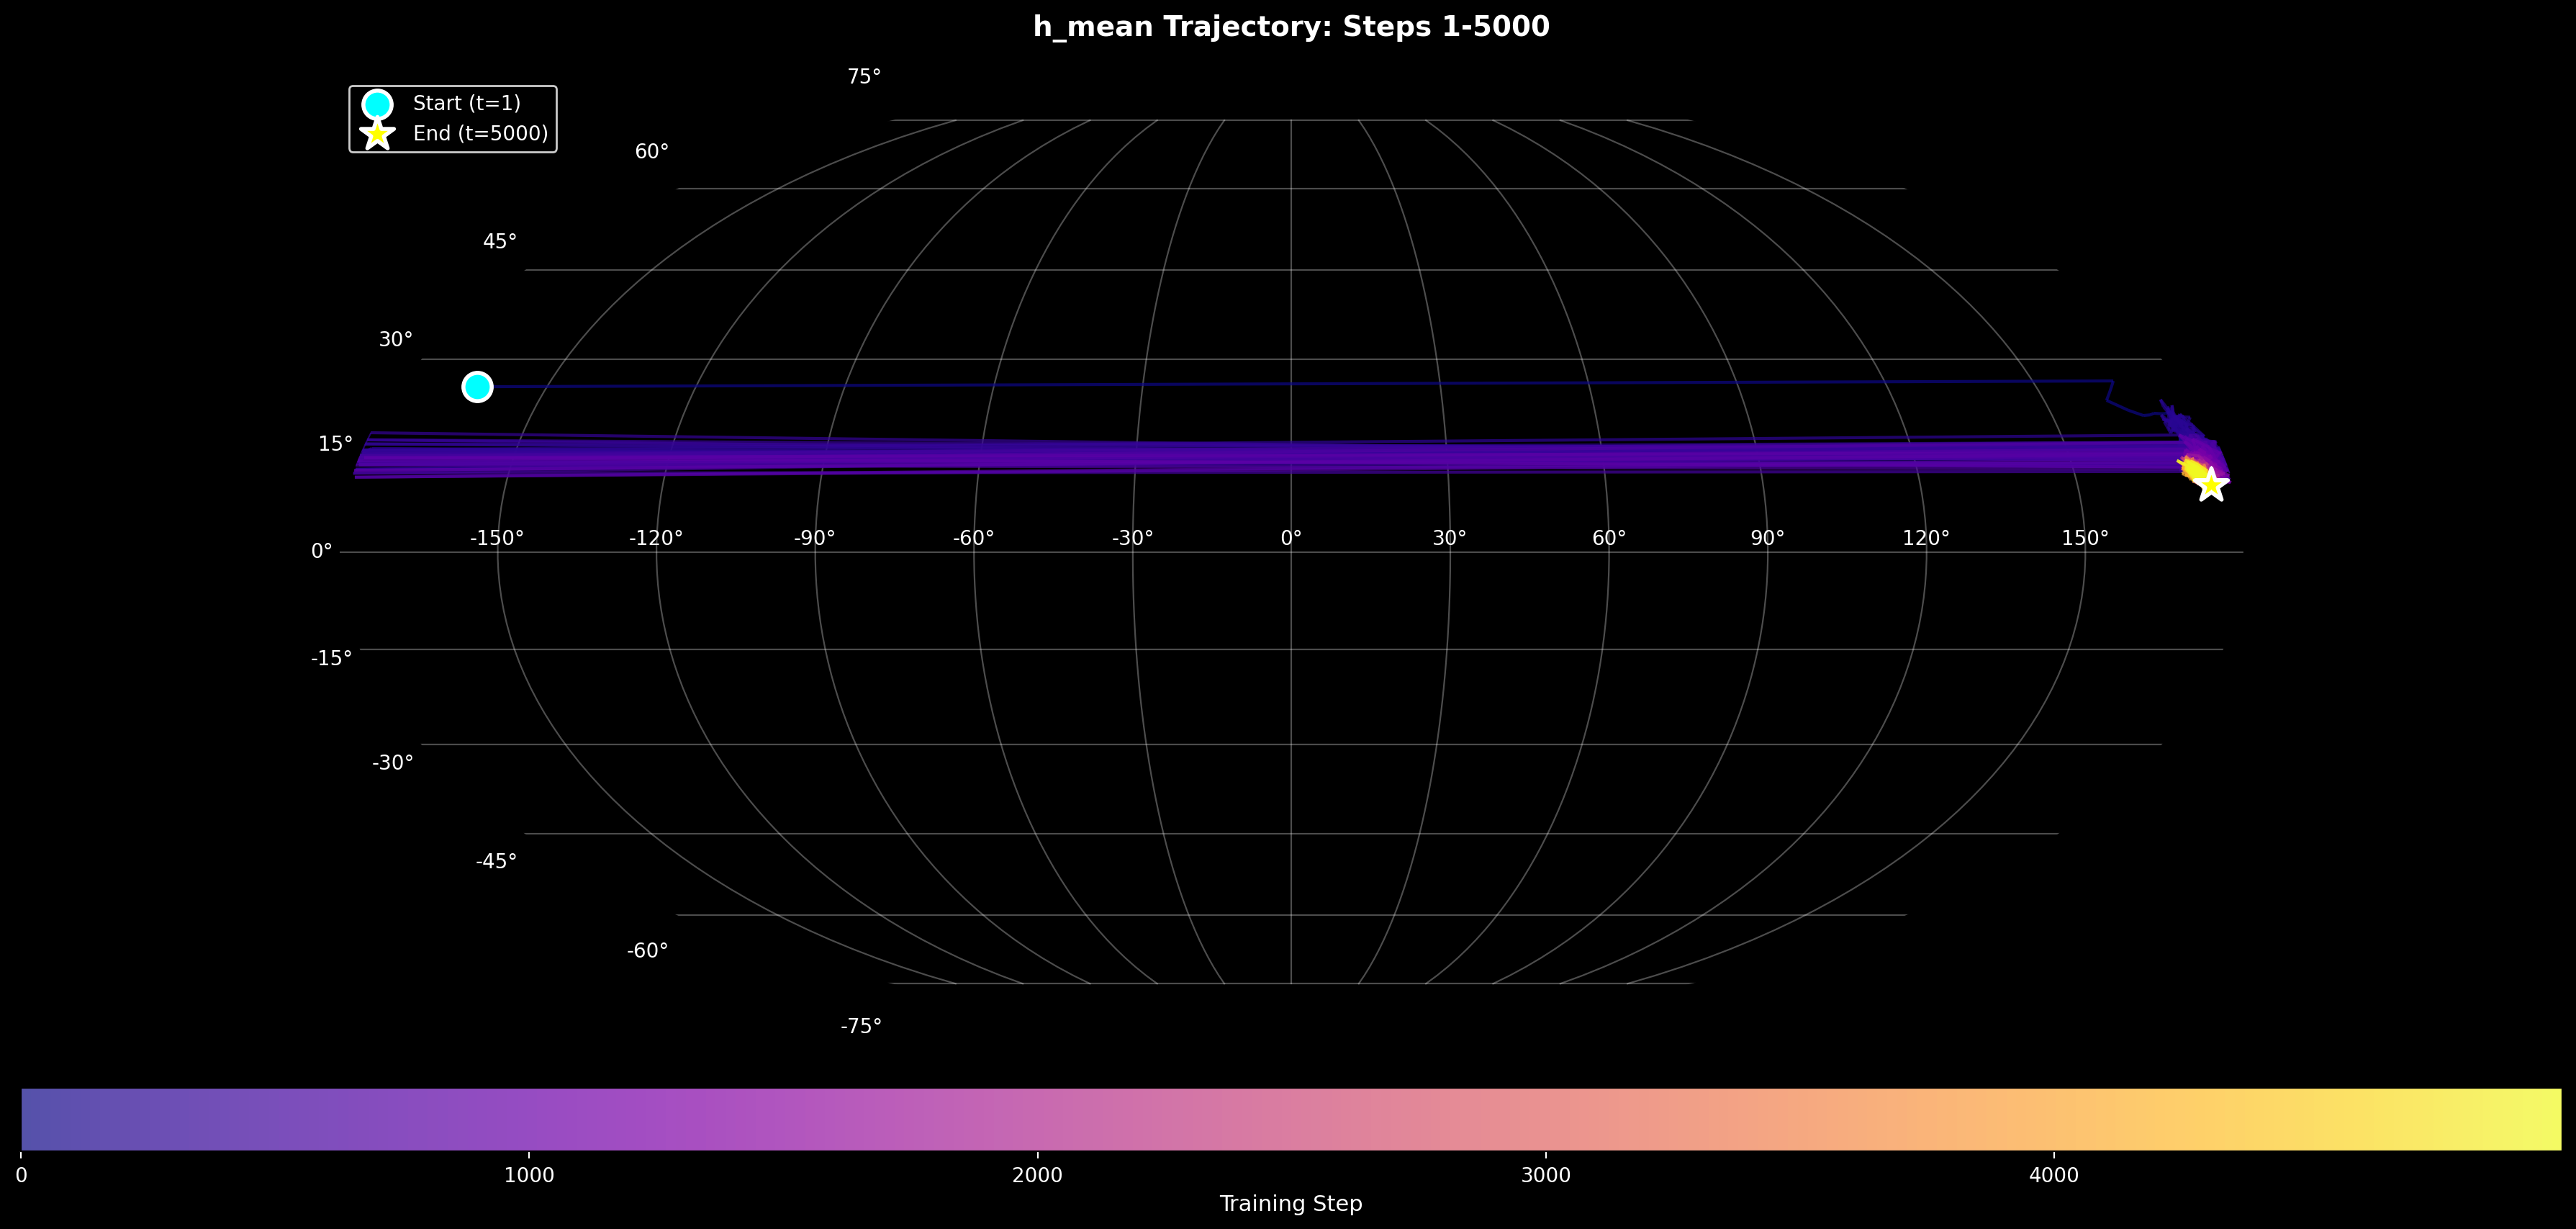

In [100]:
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Convert to radians for plotting
lon_rad = np.deg2rad(lon_trajectory.numpy())
lat_rad = np.deg2rad(lat_trajectory.numpy())

# Create line segments colored by time
points = np.array([lon_rad, lat_rad]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Color by time (early = blue, late = red)
time_steps = np.arange(len(h_mean_history))
norm = plt.Normalize(time_steps.min(), time_steps.max())

lc = LineCollection(segments, cmap='plasma', norm=norm, linewidths=LINE_WIDTH, alpha=LINE_ALPHA)
lc.set_array(time_steps[:-1])
line = ax.add_collection(lc)

# Mark start and end
ax.scatter(lon_rad[0], lat_rad[0], s=200, c='cyan', marker='o', 
           edgecolors='white', linewidths=2, label='Start (t=1)', zorder=10)
ax.scatter(lon_rad[-1], lat_rad[-1], s=300, c='yellow', marker='*', 
           edgecolors='white', linewidths=2, label='End (t=5000)', zorder=10)

# Colorbar
cbar = fig.colorbar(line, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Training Step', fontsize=11, color='white')
cbar.ax.tick_params(colors='white')

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title('h_mean Trajectory: Steps 1-5000', 
             color='white', pad=20, fontsize=14, fontweight='bold')

# Legend
legend = ax.legend(loc='upper left', fontsize=10, framealpha=0.8)
legend.get_frame().set_facecolor('black')
legend.get_frame().set_edgecolor('white')
for text in legend.get_texts():
    text.set_color('white')

# Tick colors
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color('white')

plt.tight_layout()
plt.show()

## Trajectory Statistics

In [101]:
def angular_distance(v1, v2):
    """Compute angular distance (great circle) in degrees."""
    cos_theta = torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    return torch.rad2deg(torch.acos(cos_theta))

# Total angular distance traveled
step_distances = torch.zeros(len(h_mean_history) - 1)
for t in range(len(h_mean_history) - 1):
    step_distances[t] = angular_distance(h_mean_history[t], h_mean_history[t+1])

total_distance = step_distances.sum().item()
mean_step_distance = step_distances.mean().item()
max_step_distance = step_distances.max().item()

# Net displacement (start to end)
net_displacement = angular_distance(h_mean_history[0], h_mean_history[-1]).item()

# Straightness index (net / total)
straightness = net_displacement / total_distance if total_distance > 0 else 0

print("=" * 60)
print("TRAJECTORY STATISTICS")
print("=" * 60)

print(f"\nTotal angular distance traveled: {total_distance:.2f}°")
print(f"  (Sum of step-to-step angular changes)")

print(f"\nNet displacement (start → end): {net_displacement:.2f}°")
print(f"  (Great circle distance from h[1] to h[5000])")

print(f"\nStraightness index: {straightness:.4f}")
print(f"  (net / total; 1.0 = perfectly straight, 0.0 = completely wandering)")

print(f"\nStep-to-step distances:")
print(f"  Mean: {mean_step_distance:.4f}°")
print(f"  Max:  {max_step_distance:.4f}°")

print("\n" + "=" * 60)

TRAJECTORY STATISTICS

Total angular distance traveled: 17474.80°
  (Sum of step-to-step angular changes)

Net displacement (start → end): 48.20°
  (Great circle distance from h[1] to h[5000])

Straightness index: 0.0028
  (net / total; 1.0 = perfectly straight, 0.0 = completely wandering)

Step-to-step distances:
  Mean: 3.4957°
  Max:  50.8201°



## Step Distance Over Time

Plot angular distance traveled at each step to see if h_mean swings grow larger over time.

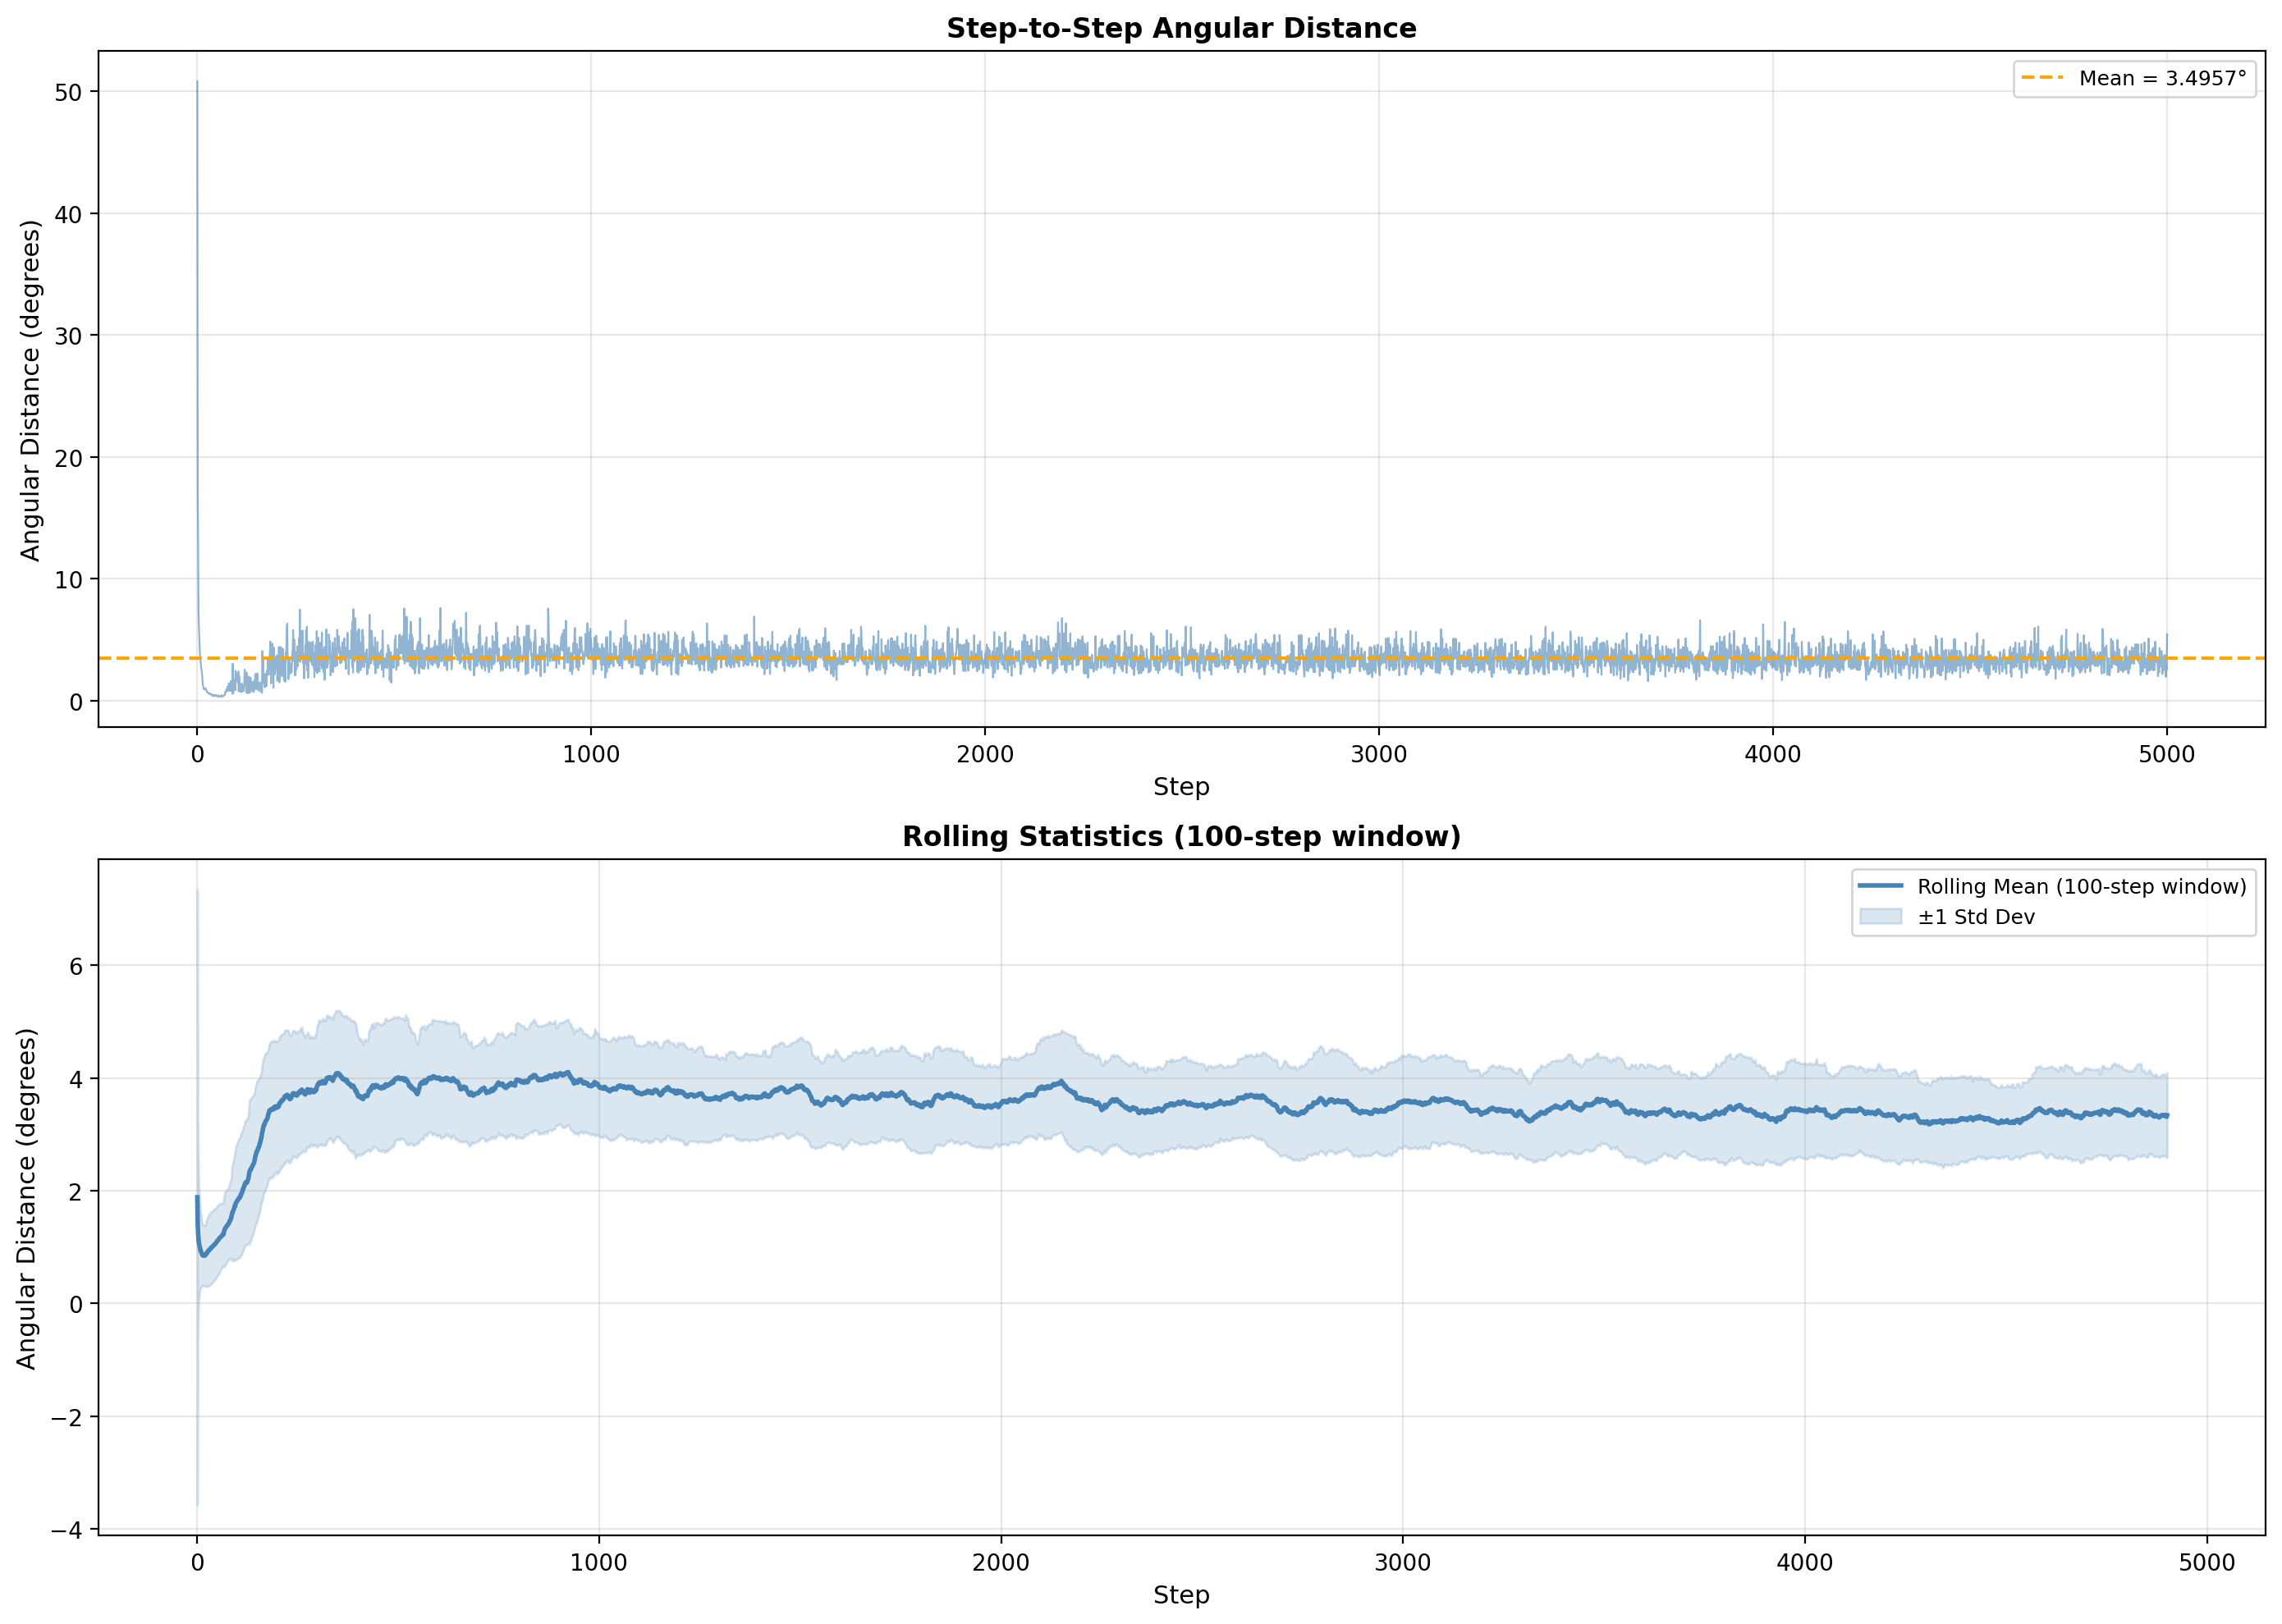

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=DPI)

steps = np.arange(1, len(step_distances) + 1)

# Top: Full time series
ax1.plot(steps, step_distances.numpy(), color='steelblue', linewidth=0.8, alpha=0.6)
ax1.axhline(y=mean_step_distance, color='orange', linestyle='--', 
            linewidth=1.5, label=f'Mean = {mean_step_distance:.4f}°')
ax1.set_xlabel('Step', fontsize=11)
ax1.set_ylabel('Angular Distance (degrees)', fontsize=11)
ax1.set_title('Step-to-Step Angular Distance', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Bottom: Rolling statistics
window = 100
rolling_mean = np.convolve(step_distances.numpy(), np.ones(window)/window, mode='valid')
rolling_std = np.array([step_distances[i:i+window].std().item() 
                        for i in range(len(step_distances) - window + 1)])

ax2.plot(steps[:len(rolling_mean)], rolling_mean, color='steelblue', 
         linewidth=2, label='Rolling Mean (100-step window)')
ax2.fill_between(steps[:len(rolling_mean)], 
                 rolling_mean - rolling_std, 
                 rolling_mean + rolling_std,
                 color='steelblue', alpha=0.2, label='±1 Std Dev')
ax2.set_xlabel('Step', fontsize=11)
ax2.set_ylabel('Angular Distance (degrees)', fontsize=11)
ax2.set_title('Rolling Statistics (100-step window)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [103]:
print("=" * 70)
print("TRAJECTORY SUMMARY")
print("=" * 70)

print(f"\n1. DOES H_MEAN LOCK IN OR WANDER?")
if straightness > 0.5:
    print(f"   Straightness index: {straightness:.4f}")
    print("   → h_mean follows relatively STRAIGHT path")
    print("   → Suggests locking onto direction early, minimal wandering")
elif straightness > 0.1:
    print(f"   Straightness index: {straightness:.4f}")
    print("   → h_mean path has MODERATE wandering")
    print("   → Some directional consistency but significant exploration")
else:
    print(f"   Straightness index: {straightness:.4f}")
    print("   → h_mean WANDERS extensively")
    print("   → Little directional consistency over training")

print(f"\n2. HOW FAR DID H_MEAN MOVE?")
print(f"   Total angular distance: {total_distance:.2f}°")
print(f"   Net displacement: {net_displacement:.2f}°")
if net_displacement < 30:
    print("   → Stayed in narrow region of sky")
elif net_displacement < 90:
    print("   → Moderate movement across sky")
else:
    print("   → Large-scale drift across sky")

print(f"\n3. DO SWINGS GROW OVER TIME?")
early_mean = step_distances[:1000].mean().item()
late_mean = step_distances[-1000:].mean().item()
print(f"   Early (steps 1-1000):      {early_mean:.4f}°")
print(f"   Late (steps 4000-5000):    {late_mean:.4f}°")
if late_mean > early_mean * 1.2:
    print("   → Swings INCREASE over training (auction attendee hypothesis)")
elif late_mean < early_mean * 0.8:
    print("   → Swings DECREASE over training (convergence)")
else:
    print("   → Swings remain STABLE over training")

print("\n" + "=" * 70)

TRAJECTORY SUMMARY

1. DOES H_MEAN LOCK IN OR WANDER?
   Straightness index: 0.0028
   → h_mean WANDERS extensively
   → Little directional consistency over training

2. HOW FAR DID H_MEAN MOVE?
   Total angular distance: 17474.80°
   Net displacement: 48.20°
   → Moderate movement across sky

3. DO SWINGS GROW OVER TIME?
   Early (steps 1-1000):      3.4548°
   Late (steps 4000-5000):    3.3351°
   → Swings remain STABLE over training



## Random Walk Hypothesis Test

Is h_mean's trajectory consistent with a random walk on the sphere?

In [104]:
# For a random walk with N steps of size s, expected net displacement ~ s × √N
N = len(h_mean_history)
s = mean_step_distance  # degrees

expected_displacement_random_walk = s * np.sqrt(N)
ratio = net_displacement / expected_displacement_random_walk

print("=" * 70)
print("RANDOM WALK HYPOTHESIS TEST")
print("=" * 70)

print(f"\nFor a 2D random walk on a sphere:")
print(f"  Number of steps (N): {N}")
print(f"  Mean step size (s): {s:.4f}°")
print(f"\n  Expected net displacement: s × √N = {expected_displacement_random_walk:.2f}°")
print(f"  Actual net displacement: {net_displacement:.2f}°")
print(f"\n  Ratio (actual / expected): {ratio:.4f}")

print(f"\nInterpretation:")
if ratio > 0.8 and ratio < 1.2:
    print(f"  ✓ Ratio ≈ 1.0: CONSISTENT with random walk")
    print(f"  → h_mean performs unbiased Brownian motion on sphere")
elif ratio < 0.5:
    print(f"  ✗ Ratio << 1.0: LESS displacement than random walk")
    print(f"  → h_mean is CONFINED or ORBITING")
    print(f"  → Some restoring force or constraint limits exploration")
else:
    print(f"  ✗ Ratio >> 1.0: MORE displacement than random walk")
    print(f"  → h_mean has directional DRIFT or BIAS")

# Check latitude confinement
lat_range = lat_trajectory.max() - lat_trajectory.min()
lon_range = lon_trajectory.max() - lon_trajectory.min()

print(f"\nLatitude range: {lat_range:.2f}°")
print(f"Longitude range: {lon_range:.2f}°")

if lon_range > 300 and lat_range < 30:
    print(f"\n  ✓ ORBITING pattern detected:")
    print(f"    - Wraps fully in longitude ({lon_range:.0f}° ≈ full circle)")
    print(f"    - Confined to narrow latitude band ({lat_range:.0f}°)")
    print(f"    → h_mean circles around a fixed latitude")

print("\n" + "=" * 70)

RANDOM WALK HYPOTHESIS TEST

For a 2D random walk on a sphere:
  Number of steps (N): 5000
  Mean step size (s): 3.4957°

  Expected net displacement: s × √N = 247.18°
  Actual net displacement: 48.20°

  Ratio (actual / expected): 0.1950

Interpretation:
  ✗ Ratio << 1.0: LESS displacement than random walk
  → h_mean is CONFINED or ORBITING
  → Some restoring force or constraint limits exploration

Latitude range: 17.35°
Longitude range: 359.90°

  ✓ ORBITING pattern detected:
    - Wraps fully in longitude (360° ≈ full circle)
    - Confined to narrow latitude band (17°)
    → h_mean circles around a fixed latitude



## Distance from Mean Position

Does h_mean orbit around a fixed center, or wander freely?

Distance from trajectory centroid:
  Mean: 5.96°
  Std:  3.16°


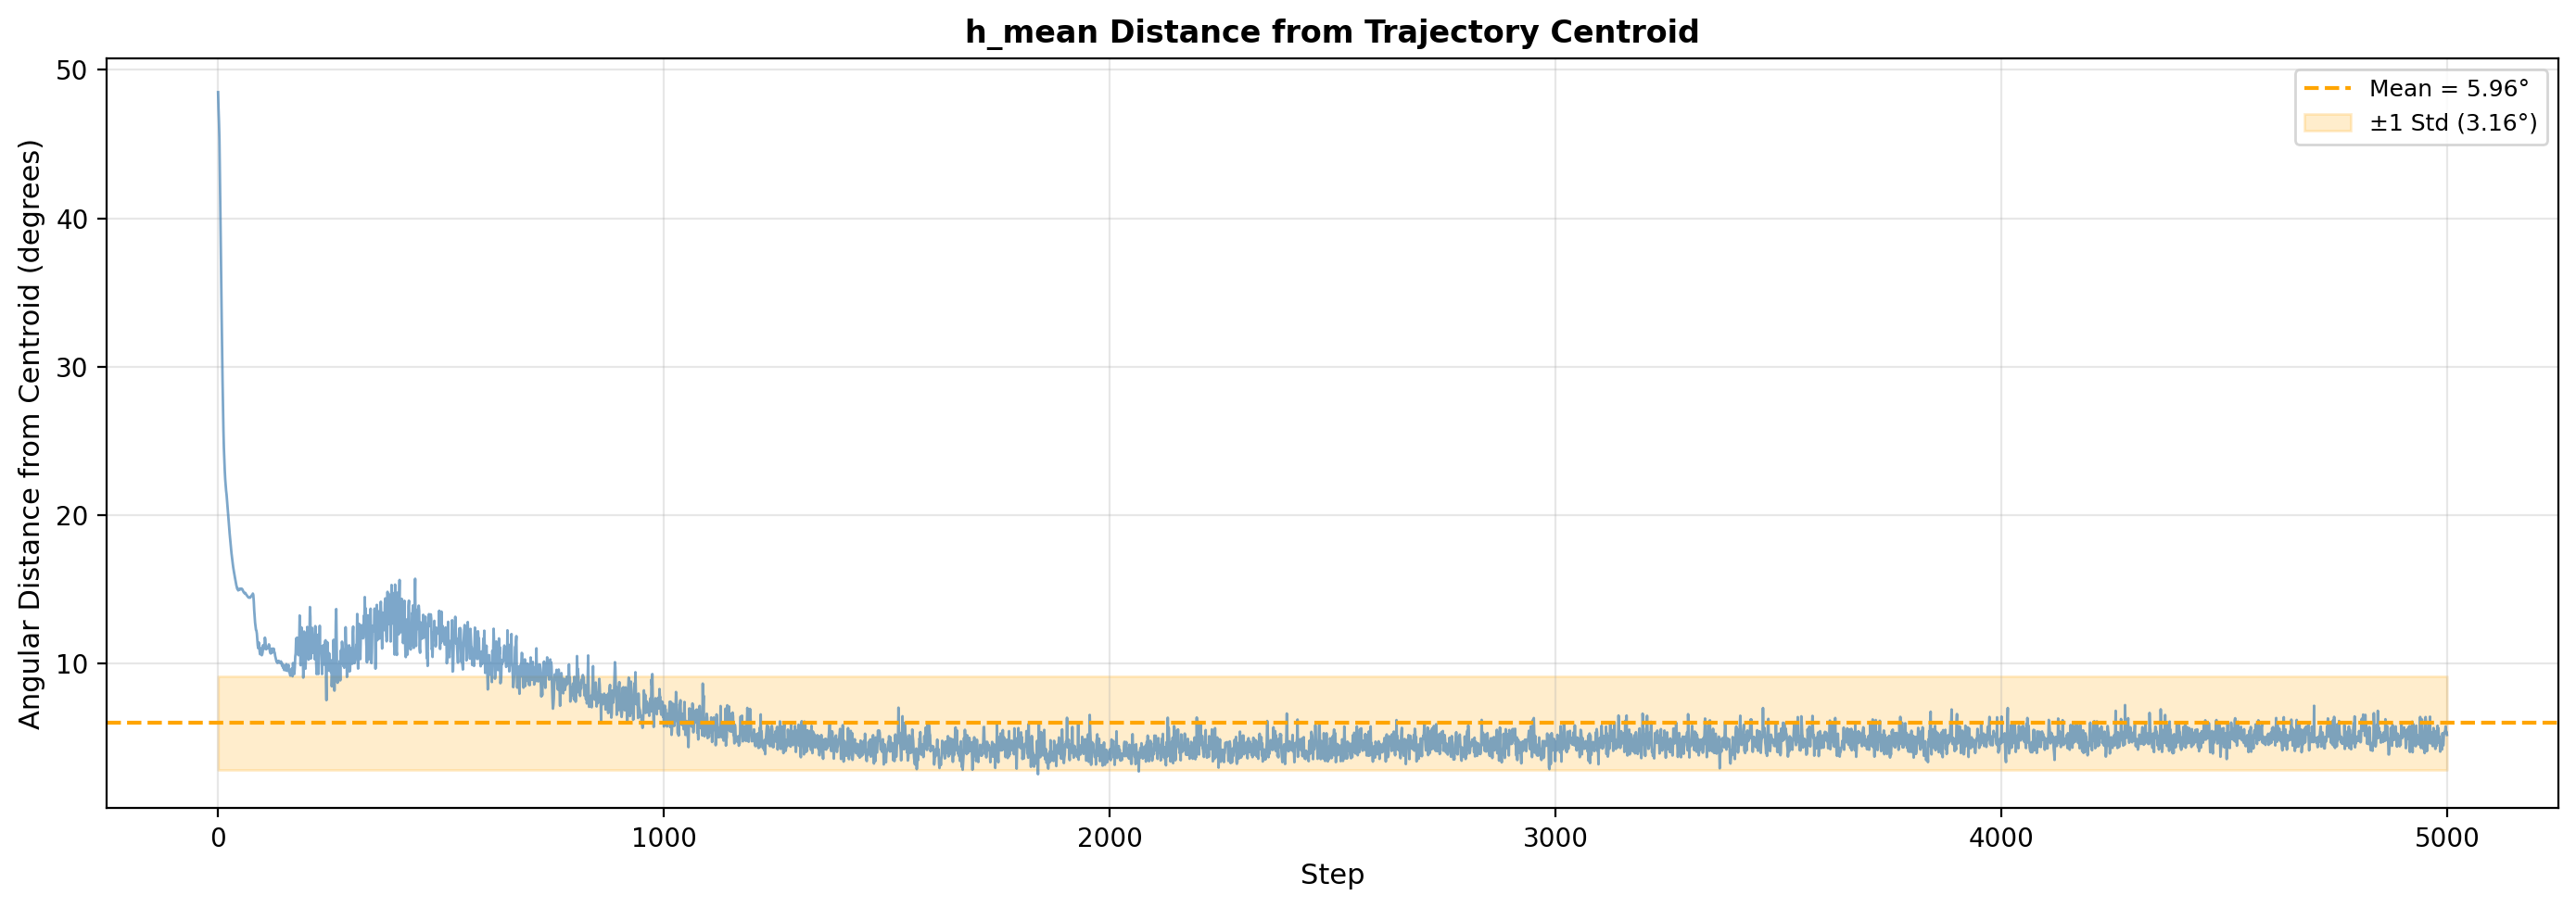


  ✗ WANDERING: std comparable to mean
    h_mean doesn't orbit a fixed center


In [105]:
# Compute mean position of h_mean over entire trajectory
h_mean_centroid = h_mean_history.mean(dim=0)
h_mean_centroid = h_mean_centroid / torch.norm(h_mean_centroid)  # Normalize to sphere

# Angular distance from each h_mean[t] to the centroid
distances_from_centroid = torch.zeros(len(h_mean_history))
for t in range(len(h_mean_history)):
    distances_from_centroid[t] = angular_distance(h_mean_history[t], h_mean_centroid)

mean_dist_from_centroid = distances_from_centroid.mean().item()
std_dist_from_centroid = distances_from_centroid.std().item()

print("Distance from trajectory centroid:")
print(f"  Mean: {mean_dist_from_centroid:.2f}°")
print(f"  Std:  {std_dist_from_centroid:.2f}°")

# Plot distance over time
fig, ax = plt.subplots(figsize=(14, 5), dpi=DPI)
ax.plot(distances_from_centroid.numpy(), color='steelblue', linewidth=1, alpha=0.7)
ax.axhline(y=mean_dist_from_centroid, color='orange', linestyle='--', 
           linewidth=1.5, label=f'Mean = {mean_dist_from_centroid:.2f}°')
ax.fill_between(range(len(distances_from_centroid)), 
                mean_dist_from_centroid - std_dist_from_centroid,
                mean_dist_from_centroid + std_dist_from_centroid,
                color='orange', alpha=0.2, label=f'±1 Std ({std_dist_from_centroid:.2f}°)')
ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Angular Distance from Centroid (degrees)', fontsize=11)
ax.set_title('h_mean Distance from Trajectory Centroid', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if std_dist_from_centroid < mean_dist_from_centroid * 0.3:
    print(f"\n  ✓ ORBITING: std << mean")
    print(f"    h_mean maintains roughly constant distance from centroid")
    print(f"    → Circular or elliptical orbit")
else:
    print(f"\n  ✗ WANDERING: std comparable to mean")
    print(f"    h_mean doesn't orbit a fixed center")

## Orbital Period Analysis

What's the period of h_mean's orbit? Is it related to epoch length?

Training context:
  Dataset: 10713 sequences
  Batch size: 128
  Epoch length: ~83 steps
  Total training: 5000 steps = 60.2 epochs

Projected 2D rotation (meridian × equinox plane):
  Total rotation: -20.46°
  Number of full orbits: -0.06

  Less than one full orbit in 5000 steps


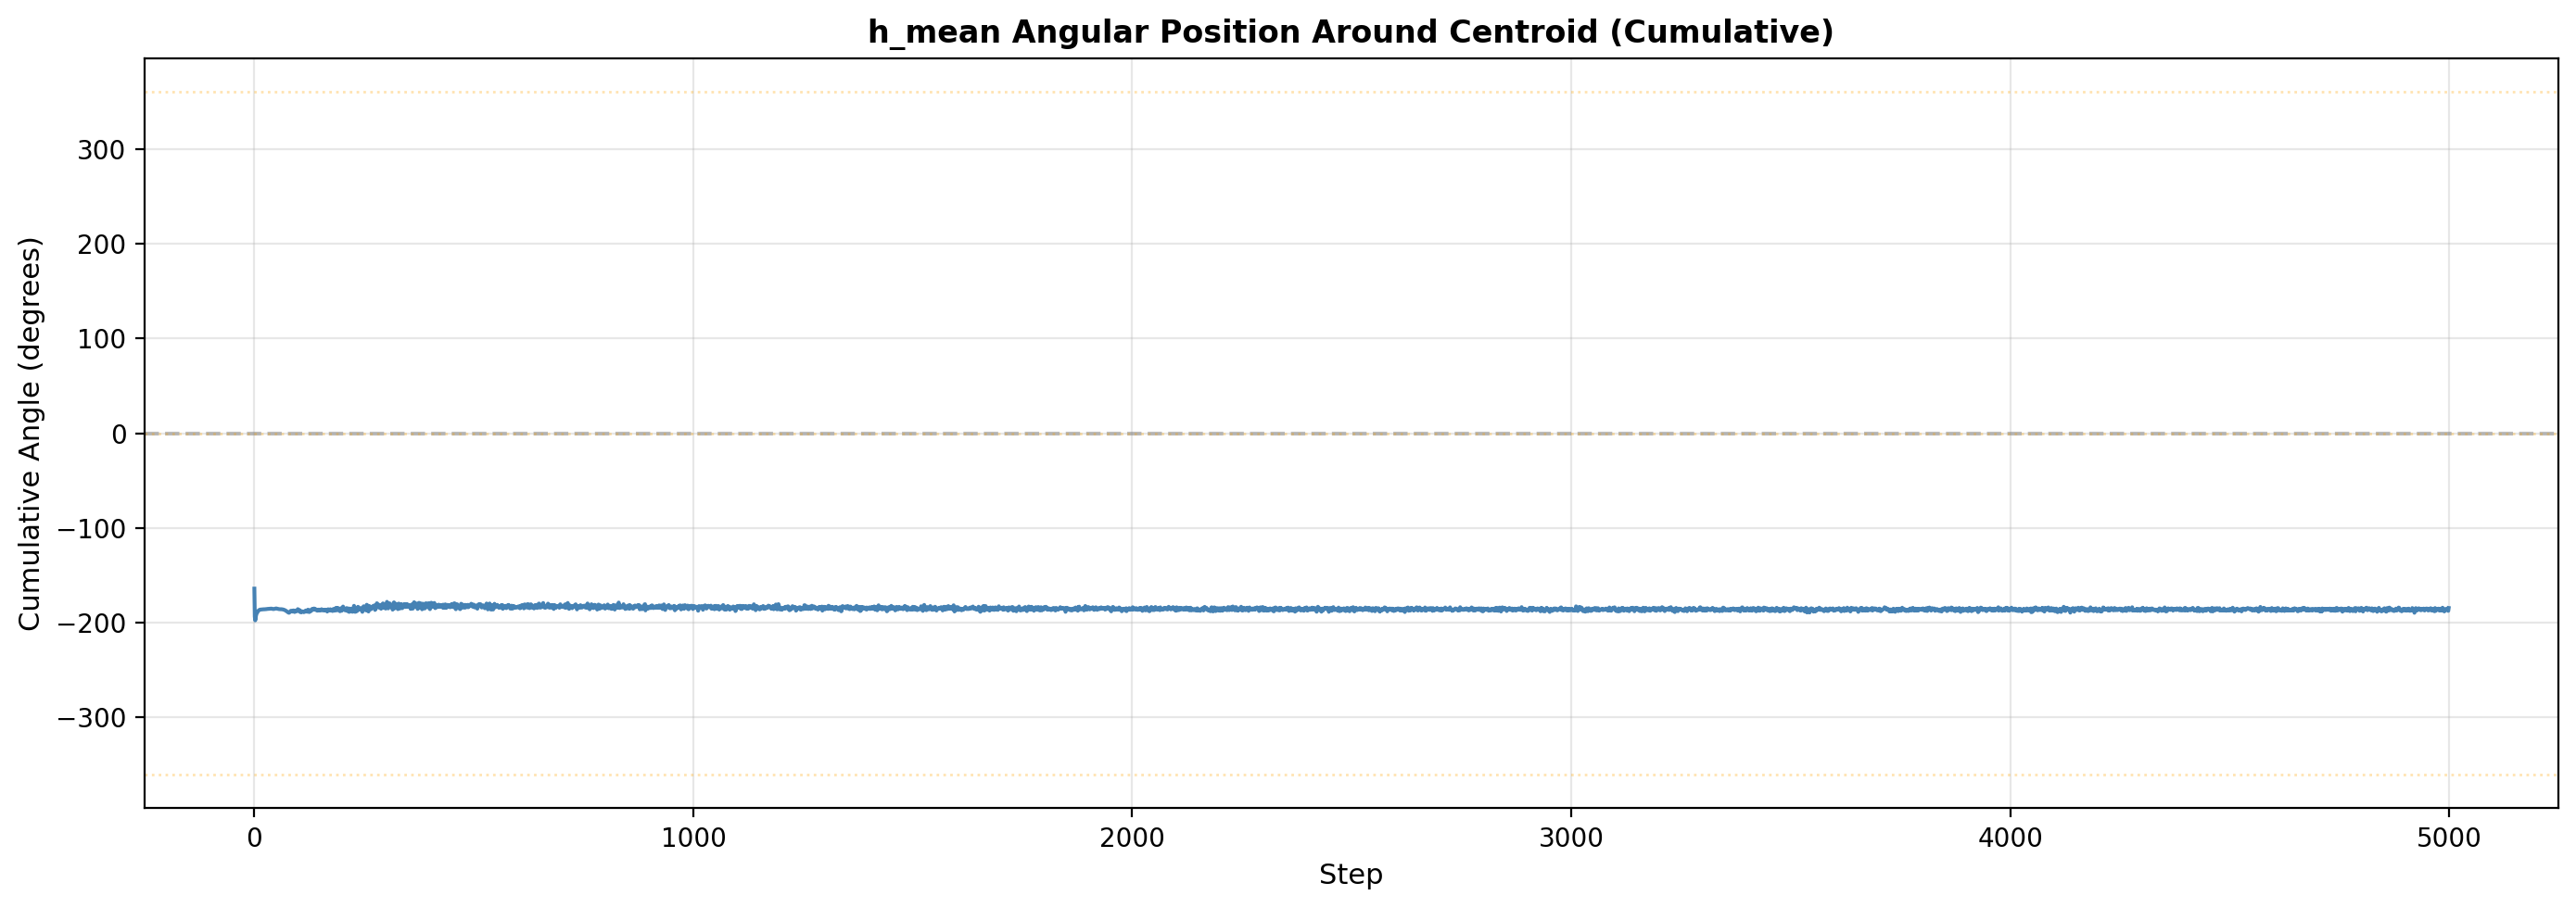

In [106]:
# Dataset size from Crucible 4 metadata
DATASET_SIZE = 10713  # sequences
BATCH_SIZE = 128
EPOCH_LENGTH_STEPS = DATASET_SIZE // BATCH_SIZE  # ~83 steps

print(f"Training context:")
print(f"  Dataset: {DATASET_SIZE} sequences")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epoch length: ~{EPOCH_LENGTH_STEPS} steps")
print(f"  Total training: 5000 steps = {5000 / EPOCH_LENGTH_STEPS:.1f} epochs")

# The problem: longitude alone doesn't capture orbital motion because h_mean 
# also moves in latitude. We need to track angular position AROUND THE CENTROID.

# Use the trajectory centroid we already computed
# Project each h_mean[t] onto the plane perpendicular to the centroid
# and measure angular position in that plane

# First, let's use a simpler approach: count zero-crossings in some component
# Project h_mean trajectory onto a 2D plane for easier period detection

# Use north and meridian as basis vectors for the plane
# (these are perpendicular by construction)
h_mean_x = (h_mean_history @ meridian.cpu()).numpy()
h_mean_y = (h_mean_history @ equinox.cpu()).numpy()

# Compute angle in this 2D projection
angles_2d = np.arctan2(h_mean_y, h_mean_x)  # radians, [-π, π]

# Count total rotation by accumulating angular changes
total_rotation_rad = 0.0
for i in range(1, len(angles_2d)):
    delta = angles_2d[i] - angles_2d[i-1]
    # Unwrap
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    total_rotation_rad += delta

total_rotation_deg = np.rad2deg(total_rotation_rad)
num_orbits = total_rotation_rad / (2 * np.pi)

print(f"\nProjected 2D rotation (meridian × equinox plane):")
print(f"  Total rotation: {total_rotation_deg:.2f}°")
print(f"  Number of full orbits: {num_orbits:.2f}")

if abs(num_orbits) > 0.5:
    period_steps = 5000 / abs(num_orbits)
    period_epochs = period_steps / EPOCH_LENGTH_STEPS
    print(f"\nOrbital period:")
    print(f"  ~{period_steps:.1f} steps/orbit")
    print(f"  ~{period_epochs:.2f} epochs/orbit")
    
    # Check if it's close to epoch length
    if abs(period_epochs - 1.0) < 0.2:
        print(f"\n  ⚠️  Period ≈ 1 epoch!")
        print(f"      Orbit synchronized with data epochs!")
    elif abs(period_steps - EPOCH_LENGTH_STEPS) < 10:
        print(f"\n  ⚠️  Period ≈ epoch length ({EPOCH_LENGTH_STEPS} steps)!")
    else:
        print(f"\n  Period does NOT match epoch length")
        print(f"  (epoch = {EPOCH_LENGTH_STEPS} steps, orbit = {period_steps:.1f} steps)")
else:
    print(f"\n  Less than one full orbit in 5000 steps")

# Cumulative angle
angles_cumulative = np.zeros(len(angles_2d))
angles_cumulative[0] = angles_2d[0]

for i in range(1, len(angles_2d)):
    delta = angles_2d[i] - angles_2d[i-1]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    angles_cumulative[i] = angles_cumulative[i-1] + delta

# Plot
fig, ax = plt.subplots(figsize=(14, 5), dpi=DPI)
ax.plot(np.rad2deg(angles_cumulative), color='steelblue', linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Mark every 360° (full orbit)
for k in range(int(np.rad2deg(angles_cumulative.min()) / 360) - 1, 
               int(np.rad2deg(angles_cumulative.max()) / 360) + 2):
    ax.axhline(y=k * 360, color='orange', linestyle=':', alpha=0.3, linewidth=1)

ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Cumulative Angle (degrees)', fontsize=11)
ax.set_title('h_mean Angular Position Around Centroid (Cumulative)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## h_mean-Native Coordinates

PCA the h_mean trajectory itself to find its natural axes of variation, then plot in that 2D subspace.

Computing PCA on h_mean trajectory...

✓ h_mean PCA computed
  Top 5 eigenvalues:
    PC1: λ = 0.407236 (52.31% variance)
    PC2: λ = 0.177663 (22.82% variance)
    PC3: λ = 0.035349 (4.54% variance)
    PC4: λ = 0.019208 (2.47% variance)
    PC5: λ = 0.016801 (2.16% variance)

Projected h_mean trajectory onto its own PC1 × PC2 plane
  These 2 PCs capture 75.13% of variance


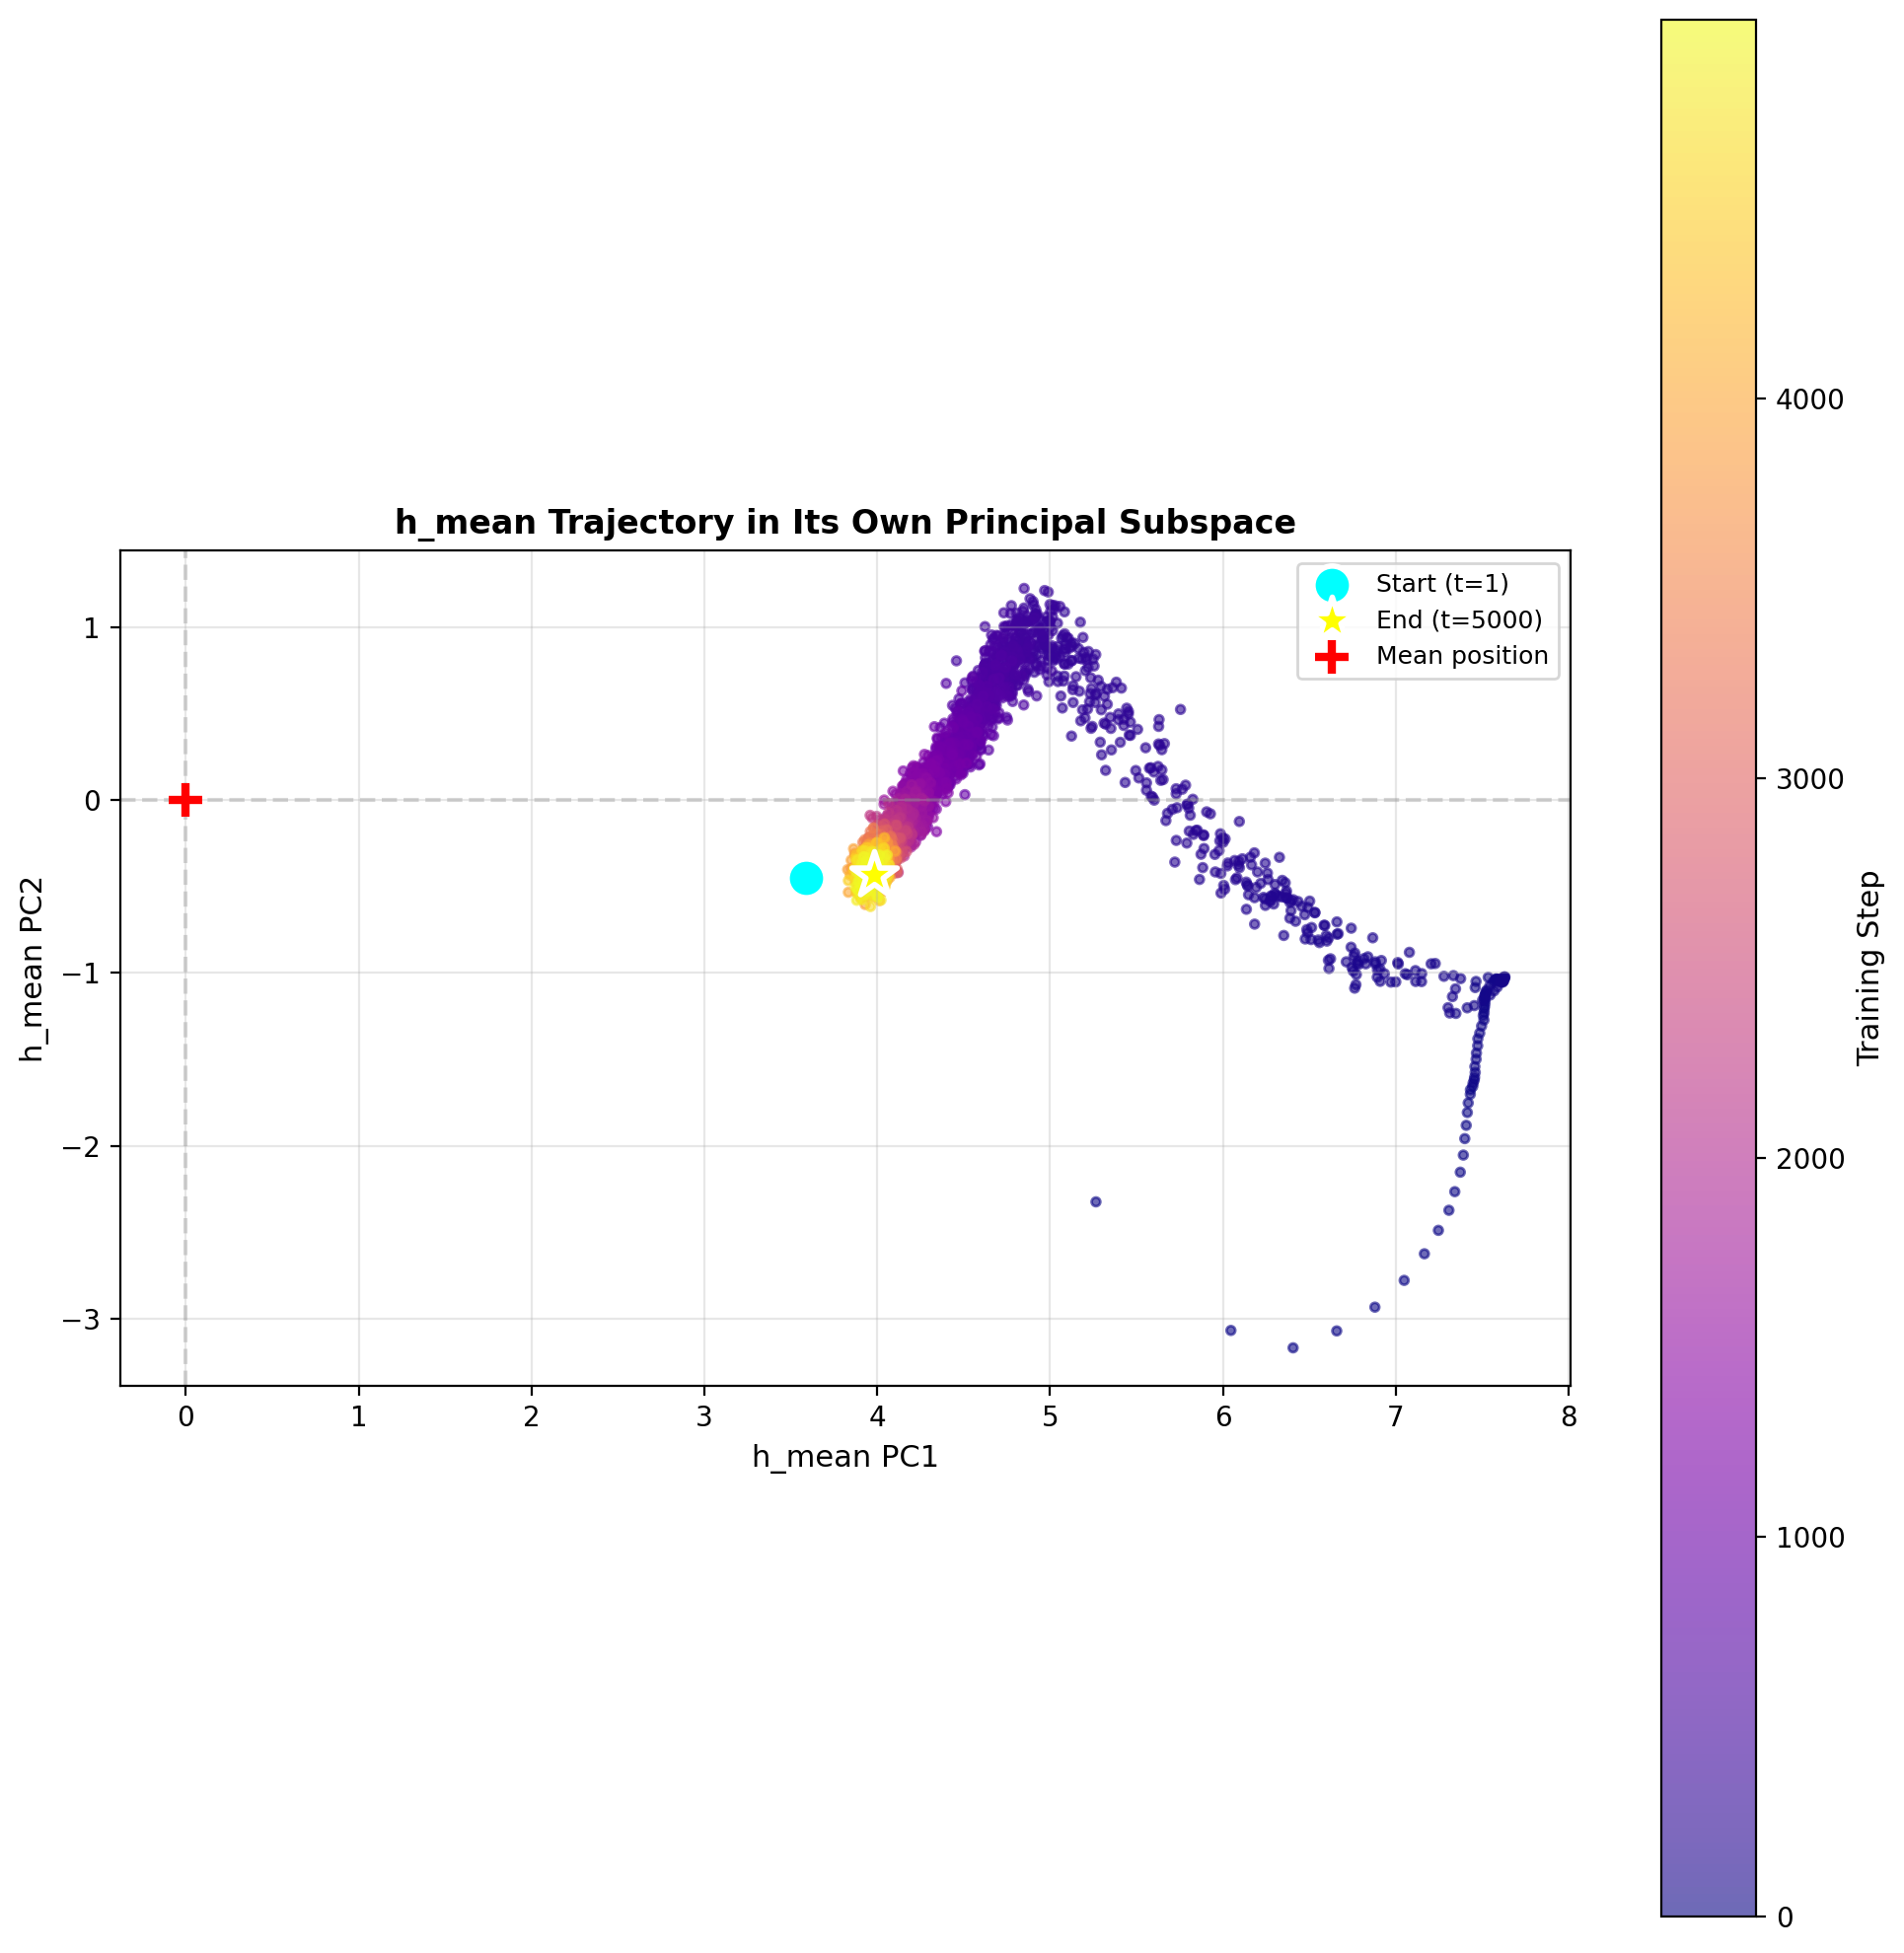

In [107]:
# PCA on h_mean trajectory (not W!)
print("Computing PCA on h_mean trajectory...")

h_mean_centered = h_mean_history - h_mean_history.mean(dim=0)

# Covariance
N_steps = h_mean_history.shape[0]
cov_h = (h_mean_centered.T @ h_mean_centered) / N_steps

# Eigendecomposition
eigenvalues_h, eigenvectors_h = torch.linalg.eigh(cov_h)

# Sort descending
idx_h = torch.argsort(eigenvalues_h, descending=True)
eigenvalues_h = eigenvalues_h[idx_h]
eigenvectors_h = eigenvectors_h[:, idx_h]

print(f"\n✓ h_mean PCA computed")
print(f"  Top 5 eigenvalues:")
for i in range(min(5, len(eigenvalues_h))):
    var_explained = eigenvalues_h[i] / eigenvalues_h.sum() * 100
    print(f"    PC{i+1}: λ = {eigenvalues_h[i].item():.6f} ({var_explained:.2f}% variance)")

# Project h_mean onto its own top 2 PCs
pc1_h = eigenvectors_h[:, 0]
pc2_h = eigenvectors_h[:, 1]

x_native = (h_mean_history @ pc1_h).numpy()
y_native = (h_mean_history @ pc2_h).numpy()

print(f"\nProjected h_mean trajectory onto its own PC1 × PC2 plane")
print(f"  These 2 PCs capture {(eigenvalues_h[0] + eigenvalues_h[1]) / eigenvalues_h.sum() * 100:.2f}% of variance")

# Plot trajectory in h_mean's natural coordinates
fig, ax = plt.subplots(figsize=(10, 10), dpi=DPI)

# Color by time
time_steps = np.arange(len(x_native))
scatter = ax.scatter(x_native, y_native, c=time_steps, cmap='plasma', 
                     s=10, alpha=0.6, rasterized=True)

# Mark start and end
ax.scatter(x_native[0], y_native[0], s=200, c='cyan', marker='o',
           edgecolors='white', linewidths=2, label='Start (t=1)', zorder=10)
ax.scatter(x_native[-1], y_native[-1], s=300, c='yellow', marker='*',
           edgecolors='white', linewidths=2, label='End (t=5000)', zorder=10)

# Mark origin (mean position)
ax.scatter(0, 0, s=150, c='red', marker='+', linewidths=3,
           label='Mean position', zorder=10)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Training Step', fontsize=11)

# Formatting
ax.set_xlabel('h_mean PC1', fontsize=11)
ax.set_ylabel('h_mean PC2', fontsize=11)
ax.set_title('h_mean Trajectory in Its Own Principal Subspace', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## What Token is h_mean Pointing At?

If h_mean is converging to a fixed direction, which token(s) does that correspond to?

In [108]:
# Compute unembedding logits for h_mean at different time points
# logits = h_mean @ W.T

# Load tokenizer for decoding
from tokenizers import Tokenizer
TOKENIZER_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_tokenizer_chars.json'
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))

# Get dead_mask from loaded data
dead_mask = data['dead_mask'].bool()

# Time points to check
check_steps = [1, 100, 500, 1000, 2500, 5000]

print("Computing unembedding logits for h_mean at key time points...")
print("=" * 70)

for step_idx in check_steps:
    if step_idx > len(h_mean_history):
        continue
    
    h = h_mean_history[step_idx - 1]  # h_mean is 0-indexed
    W = data['W'][step_idx].view(torch.bfloat16).float()
    
    # Unembedding: logits = h @ W.T
    logits = h @ W.T  # (10000,)
    
    # Top-5 tokens by logit
    top_logits, top_indices = torch.topk(logits, k=5)
    
    print(f"\nStep {step_idx}:")
    print(f"  Top 5 predicted tokens (by logit):")
    for rank, (idx, logit) in enumerate(zip(top_indices, top_logits), 1):
        token_id = idx.item()
        is_dead = dead_mask[token_id].item()
        status = "DEAD" if is_dead else "live"
        token_str = tokenizer.decode([token_id])
        # Show repr for non-printable chars
        token_repr = repr(token_str) if token_str.isprintable() else repr(token_str)
        print(f"    {rank}. Token {token_id:5d} ({status}): {token_repr:20s} logit = {logit.item():7.3f}")
    
    # Check if top token changes over time
    if step_idx == check_steps[0]:
        first_top_token = top_indices[0].item()
    elif step_idx == check_steps[-1]:
        final_top_token = top_indices[0].item()

print(f"\n" + "=" * 70)
print(f"CONVERGENCE CHECK:")
first_token_str = tokenizer.decode([first_top_token])
final_token_str = tokenizer.decode([final_top_token])
print(f"  Step {check_steps[0]} top token: {first_top_token} ({repr(first_token_str)})")
print(f"  Step {check_steps[-1]} top token: {final_top_token} ({repr(final_token_str)})")
if first_top_token == final_top_token:
    print(f"  ✓ Same token throughout training!")
else:
    print(f"  ✗ Top token changed")
print("=" * 70)

Computing unembedding logits for h_mean at key time points...

Step 1:
  Top 5 predicted tokens (by logit):
    1. Token  3650 (live): 'iel'                logit =   0.488
    2. Token  5010 (live): 'Spe'                logit =   0.407
    3. Token  5695 (live): 'projects'           logit =   0.397
    4. Token  2908 (live): 'so'                 logit =   0.351
    5. Token  3149 (live): 'cor'                logit =   0.344

Step 100:
  Top 5 predicted tokens (by logit):
    1. Token    16 (live): '.'                  logit =   5.041
    2. Token    14 (live): ','                  logit =   5.005
    3. Token  2806 (live): 'the'                logit =   4.876
    4. Token  2818 (live): 'and'                logit =   4.431
    5. Token  2815 (live): 'to'                 logit =   4.414

Step 500:
  Top 5 predicted tokens (by logit):
    1. Token    14 (live): ','                  logit =   4.795
    2. Token    16 (live): '.'                  logit =   4.739
    3. Token  2818 (live): '